In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

In [18]:
# read scraped data 
df_more = pd.read_csv('Indeed_data.csv')
job_description = open('JD.txt').read().split('\n BREAKS HERE')
job_description = job_description[:-1]
print len(job_description)
print type(job_description[0])

TypeError: 'encoding' is an invalid keyword argument for this function

## Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root.


In [4]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 179 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
tokenization_and_stemming("3+ years in analytics experience solving real-world business problems or doing analytics/data science research")

[u'year',
 u'analyt',
 u'experi',
 u'solv',
 u'real-world',
 u'busi',
 u'problem',
 u'analytics/data',
 u'scienc',
 u'research']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [19]:
docs_stemmed = []
docs_tokenized = []
for s in job_description:
    s = s.decode('utf-8')
    tokenized_and_stemmed_results = tokenization_and_stemming(s)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(s)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [20]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['busi']

business


# TF-IDF

In [22]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(job_description) #fit the vectorizer to job description

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " job postings and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 2833 job postings and 192 terms.


In [23]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [24]:
tf_selected_words = tfidf_model.get_feature_names()

## Calculate Similarity

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[1.         0.1647529  0.39765786 ... 0.4631791  0.31851519 0.30794575]
 [0.1647529  1.         0.16592696 ... 0.20114115 0.12643034 0.15356536]
 [0.39765786 0.16592696 1.         ... 0.19288122 0.25439576 0.13328914]
 ...
 [0.4631791  0.20114115 0.19288122 ... 1.         0.28648621 0.16893799]
 [0.31851519 0.12643034 0.25439576 ... 0.28648621 1.         0.24174093]
 [0.30794575 0.15356536 0.13328914 ... 0.16893799 0.24174093 1.        ]]


# K-means Clustering

In [26]:
from sklearn.cluster import KMeans

num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [27]:
print len(clusters)

2833


## Check K-means results

In [29]:
# create DataFrame films from all of the input files.
np.array(clusters)  
df_more['cluster'] = pd.Series(np.array(clusters) , index=df_more.index)
#df_more = df_more.drop(['Unnamed: 0','Unnamed: 0.1'], 1)
df_more.head(10)

,Title,Search,Location,Company,detail_url,cluster
0,Data Scientist,Data+scientist,"Chicago, IL",Synchrony,/rc/clk?jk=619f469f4881f114&fccid=bfac37d9f1a8...,1
1,FBI Intelligence Analyst,Data+scientist,"Chicago, IL",Federal Bureau of Investigation,/company/Federal-Bureau-of-Investigation/jobs/...,0
2,Data Scientist,Data+scientist,"Chicago, IL",Trunk Club,/rc/clk?jk=993c4712bb3a0a52&fccid=0071370f02db...,1
3,"Data Scientist, Customer Insights",Data+scientist,"Chicago, IL 60654 (Loop area)",Groupon,/rc/clk?jk=4299d0cb3d242cb8&fccid=863ad2cc91c9...,1
4,Credit Audit Data Scientist & Analyst,Data+scientist,"Chicago, IL",BMO Financial Group,/company/BMO-Harris-Bank/jobs/Credit-Audit-Dat...,0
5,Data Scientist,Data+scientist,"Chicago, IL 60606 (Loop area)",Numerator,/rc/clk?jk=97cbcb6aa8a53cf4&fccid=11f2ca9fb727...,1
6,Data Scientist,Data+scientist,"Chicago, IL",ActiveCampaign,/rc/clk?jk=24587a316659ebfb&fccid=9c2be00e2f57...,1
7,Associate Data Scientist Intern,Data+scientist,"Chicago, IL 60603 (Loop area)",The Marketing Store,/rc/clk?jk=4f6c01fe6410709f&fccid=a5a3009925a5...,1
8,Associate Data Scientist,Data+scientist,"Chicago, IL","Blue Cross Blue Shield of IL, MT, NM, ...",/rc/clk?jk=cacf4449907b563d&fccid=f0982fe98d8e...,1
9,Data Scientist Associate,Data+scientist,"Schaumburg, IL 60173",Zurich North America,/rc/clk?jk=cb2c41d968993fe1&fccid=34938366d451...,1


In [30]:
# convert search to ints
cleanup_nums = {"Search":     {'Data+scientist': 0, 'Machine+learning engineer': 1, 'Data+analyst': 2},}
df_more.replace(cleanup_nums, inplace=True)
df_more.head()

,Title,Search,Location,Company,detail_url,cluster
0,Data Scientist,0,"Chicago, IL",Synchrony,/rc/clk?jk=619f469f4881f114&fccid=bfac37d9f1a8...,1
1,FBI Intelligence Analyst,0,"Chicago, IL",Federal Bureau of Investigation,/company/Federal-Bureau-of-Investigation/jobs/...,0
2,Data Scientist,0,"Chicago, IL",Trunk Club,/rc/clk?jk=993c4712bb3a0a52&fccid=0071370f02db...,1
3,"Data Scientist, Customer Insights",0,"Chicago, IL 60654 (Loop area)",Groupon,/rc/clk?jk=4299d0cb3d242cb8&fccid=863ad2cc91c9...,1
4,Credit Audit Data Scientist & Analyst,0,"Chicago, IL",BMO Financial Group,/company/BMO-Harris-Bank/jobs/Credit-Audit-Dat...,0


In [31]:
print "Number of jobs included in each cluster:"
df_more['cluster'].value_counts().to_frame()

Number of jobs included in each cluster:


,cluster
0,996
2,980
1,857


In [37]:
print "<Document clustering result by K-means>"

# km.cluster_centers_ denotes the importances of each items in centroid.
# need to sort it in descending order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :15]: # get the top 6 words of each cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ", ",
    print 

    cluster_jobs = df_more.loc[df_more.cluster == i, 'Title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_jobs)) + " jobs): " 
    #print ", ".join(cluster_jobs), '\n'

<Document clustering result by K-means>
Cluster 0 words: reports,  management,  required,  analysts,  support,  business,  including,  analysis,  skills,  research,  project,  teams,  providing,  develop,  year, 
Cluster 0 titles (996 jobs): 
Cluster 1 words: business,  analytics,  modeling,  statistical,  teams,  science,  production,  analysis,  insights,  use,  marketing,  learn,  customer,  develop,  build, 
Cluster 1 titles (857 jobs): 
Cluster 2 words: learn,  machine,  engineering,  develop,  teams,  software,  technology,  production,  build,  computer,  designed,  science,  applications,  algorithms,  new, 
Cluster 2 titles (980 jobs): 


In [35]:
print len(order_centroids[1,:])

192


## Plot result

In [38]:
pca = decomposition.PCA(n_components=3)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: 'g', 1: 'b', 2: 'r', 3: 'y', 4:'k',5:'m'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

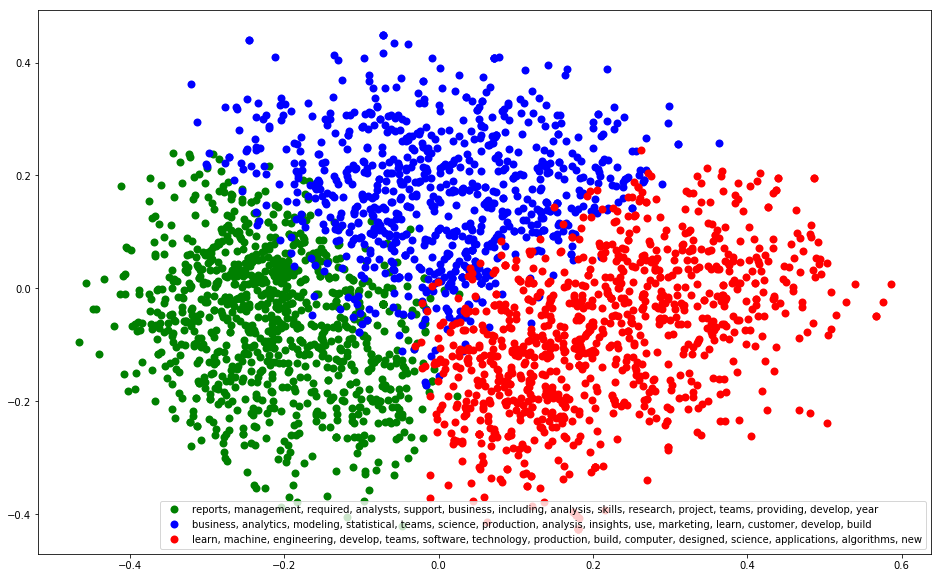

In [41]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 10))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

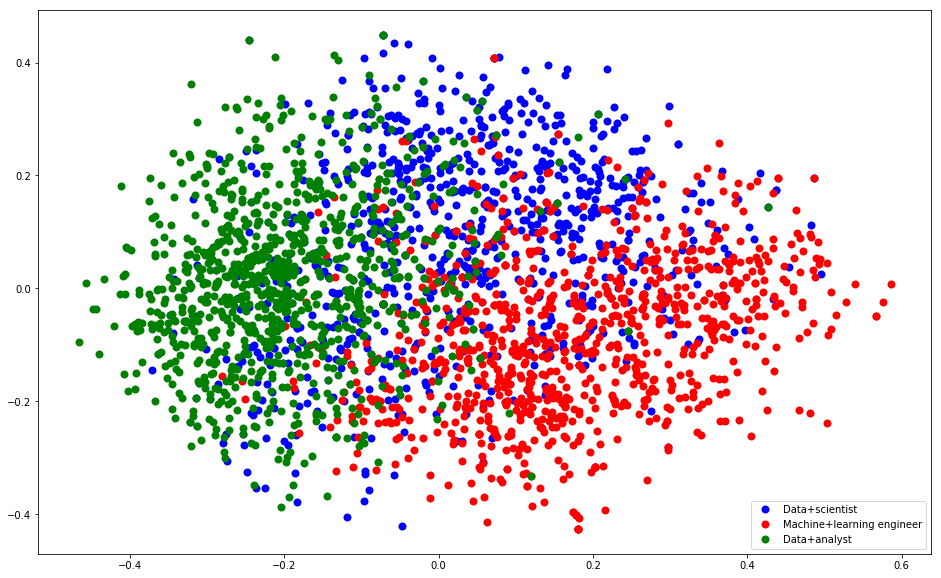

In [46]:
%matplotlib inline 
search_names = ['Data+scientist', 'Machine+learning engineer', 'Data+analyst']
#create data frame with PCA cluster results
search_num = df_more['Search'].tolist()
df_indeed = pd.DataFrame(dict(x=xs, y=ys, label=search_num)) 
groups2 = df_indeed.groupby(search_num)

# set up plot
cluster_colors2 = {0: 'b', 1: 'r', 2: 'g', 3: 'y', 4:'k',5:'m'}

fig, ax = plt.subplots(figsize=(16, 10))
#Set color for each cluster/group
for name, group in groups2:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=search_names[name], color=cluster_colors2[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

# LDA

In [63]:
#Now we use synopses to build a 100*551 matrix (terms)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=4, learning_method = 'online')

tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [64]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [65]:
topic_word = lda.components_
print topic_word.shape

(4, 192)


In [66]:
n_top_words = 20
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [67]:
topic_keywords_list

[[u'customer',
  u'teams',
  u'develop',
  u'technology',
  u'designed',
  u'software',
  u'test',
  u'business',
  u'production',
  u'service',
  u'management',
  u'solutions',
  u'technical',
  u'support',
  u'engineerin',
  u'process',
  u'build',
  u'user',
  u'quality'],
 [u'employment',
  u'status',
  u'disabiliti',
  u'gender',
  u'applicatio',
  u'protected',
  u'equal',
  u'national',
  u'veterans',
  u'opportunit',
  u'orientatio',
  u'origin',
  u'sexual',
  u'race',
  u'color',
  u'religion',
  u'identity',
  u'age',
  u'employee'],
 [u'learn',
  u'machine',
  u'modeling',
  u'science',
  u'statistica',
  u'engineerin',
  u'teams',
  u'production',
  u'algorithms',
  u'business',
  u'computer',
  u'analytics',
  u'build',
  u'scientist',
  u'use',
  u'deep',
  u'develop',
  u'python',
  u'predictive'],
 [u'reports',
  u'analysts',
  u'required',
  u'analysis',
  u'research',
  u'management',
  u'skills',
  u'clients',
  u'ability',
  u'position',
  u'analytics',
  u'marketi

In [68]:
doc_topic = lda.transform(tfidf_matrix_lda)
print doc_topic.shape

(2833, 4)


In [69]:
print doc_topic[:,1]

[0.16982228 0.06103602 0.00037711 ... 0.29614107 0.00043033 0.00062197]


In [70]:
topic_doc_dict = {}
titles = df_more['Title'].tolist()

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " jobs): " 
    #print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: customer, teams, develop, technology, designed, software, test, business, production, service, management, solutions, technical, support, engineerin, process, build, user, quality
Cluster 0 titles (629 jobs): 

Cluster 1 words: employment, status, disabiliti, gender, applicatio, protected, equal, national, veterans, opportunit, orientatio, origin, sexual, race, color, religion, identity, age, employee
Cluster 1 titles (361 jobs): 

Cluster 2 words: learn, machine, modeling, science, statistica, engineerin, teams, production, algorithms, business, computer, analytics, build, scientist, use, deep, develop, python, predictive
Cluster 2 titles (1067 jobs): 

Cluster 3 words: reports, analysts, required, analysis, research, management, skills, clients, ability, position, analytics, marketing, preference, including, excellence, year, types, support, perform
Cluster 3 titles (776 jobs): 



We got a similar set of three clusters/topics as those we got with KMeans, but the topic keywords are different.

